# SymPy example for Structural Mechanics problems 

With SymPy, a very powerfull computer algebra tool, mechanics problems can be solved in an easy and fast way. It will take over the cumbersome handcalculations. However the engineering part; the thinking, the modelling and the correct input of the specifications still remains a human matter. 
A simple beam is taken as an example. The beam is loaded with a uniform load `q` on a part of the beam and a force `F`. All loads are considered to be static loads. The beam is a prismatic beam with a bending stiffness `EI`.

![figuur 3](data/Data_SymPy_example_for_Structural_Mechanics_problems/Beam.gif)

With SymPy the beam deflections and the moment and shear distribution along the beam axis will be computed. The model used is the beam-model which can be discribed with the fourth order differential equation (DE):

$EI{{{d^4}w} \over {d{x^4}}} = q\left( x \right)$

The solution of the problem can only be found with the correct boundary conditions. In this simple case the four required boundary conditions are: 
- $w(0)=0$
- $M(0)=0$
- $w(L)=0$
- $M(L)=0$

The DE is only valid for domains were the load distibution is continuous differentiable. If the problem is worked out by hand we should have to split the problem in to three domains. Each discontinuity in the loading or the beamproperties urges for a split. Each domain requires four boundary conditions. This would result in 12 boundary conditions. Four of these conditions 
are specified on the outer boundaries of the problem, the other eight are specified on the two connections between the three domains. If we solve this problem with SymPy (see [Alternative implementation](#3_ODE) ) however this approach is not necessary. If the load can be specified as one continous differentiable function along the total beam axis we can model the beam as one domain.
How can we describe the load as one function which is valid for the total beam length? The uniform load `q` can be modelled with a `sympy.Heaviside` function (step function, see Calculus page 49 and 95) and the force `F` can be modelled with a `sympy.DiracDelta` or δ-function. Both functions can be found in the standard mathematics text books or in the help of SymPy.

In SymPy the modelling of the load looks like this (the 35 kN is not visible in the plot):

35*DiracDelta(x - 9) - 10*Heaviside(x - 4) + 10

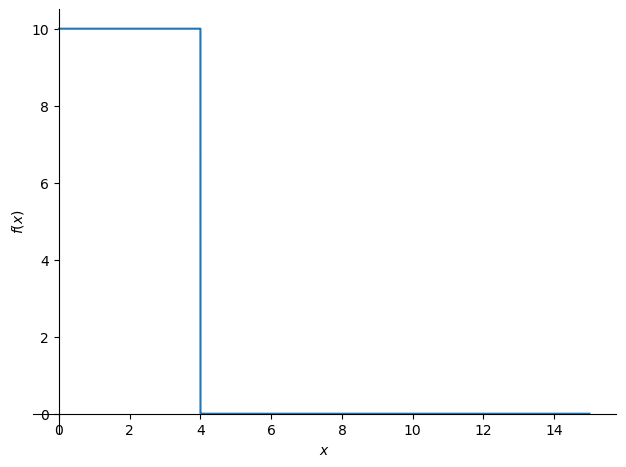

In [1]:
import sympy as sp
w = sp.symbols('w', cls=sp.Function)
x = sp.symbols('x')
C1, C2, C3, C4 = sp.symbols('C1 C2 C3 C4') 

Q = 10
L = 15
a = 4
b = 5
F = 35

q = Q*(1 - sp.Heaviside(x-a))+F*sp.DiracDelta(x-(a+b))
display(q)
sp.plot(q,(x,0,L));

In the plot of the load function `q` the force `F` is not visible. However the load exists, this can 
seen by calculating the total load with the integral of the load function. 

The differential equation can now be specified and solved with SymPy: 

In [2]:
EI = 10000
diffeq = sp.Eq(EI*sp.diff(w(x),x,4),q)

w = sp.dsolve(diffeq,w(x))
#to obtain a neat solution, an alternative is to integrate four times with the option meijerg=False.
#implementation of a similar issue is under consideration: https://groups.google.com/g/sympy/c/olLV1La7bKs
w = w.rhs
display(w)

C1 + x**4/24000 + x**3*(C4 - Piecewise((0, Abs(x) < 4), (4*meijerg(((2, 1), ()), ((), (1, 0)), x/4), True))/6000 + 7*Heaviside(x - 9)/12000) + x**2*(C3 + Piecewise((0, Abs(x) < 4), (16*meijerg(((3, 1), ()), ((), (2, 0)), x/4), True))/2000 - 63*Heaviside(x - 9)/4000) + x*(C2 - Piecewise((0, Abs(x) < 4), (64*meijerg(((4, 1), ()), ((), (3, 0)), x/4), True))/2000 + 567*Heaviside(x - 9)/4000) + Piecewise((0, Abs(x) < 4), (256*meijerg(((5, 1), ()), ((), (4, 0)), x/4), True))/6000 - 1701*Heaviside(x - 9)/4000

To store the general solution `w(x)` in a simple the function denoted with the variable `w`, we use the righthandside function `.rhs`. This means the right hand side of the resulting `sp.dsolve` operation is stored in the variable `w`.

In [3]:
phi = -sp.diff(w,x)
kappa = sp.diff(phi,x)
M = EI * kappa
V = sp.diff(M,x)
           
Eq1 = sp.Eq(w.subs(x,0),0)
Eq2 = sp.Eq(w.subs(x,L),0)
Eq3 = sp.Eq(M.subs(x,0),0)
Eq4 = sp.Eq(M.subs(x,L),0)

sol = sp.solve((Eq1,Eq2,Eq3,Eq4),(C1,C2,C3,C4))
w = w.subs(sol)

The boundary conditions are specified with four equations `eq1` ... `eq4` which have to be solved with the `sp.solve` command. The solution of the integration constants has to be substituted in our general solution with `.subs`.

The results of the calculation can best be viewed with a plot. 

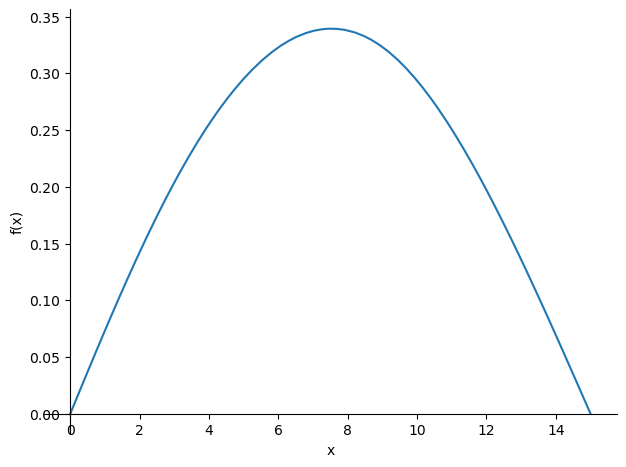

In [4]:
sp.plotting.plot(w,(x,0,L));

The moment and shear distribution can be found with the known relations between the moment and the displacement field and the moment and the shear forces.

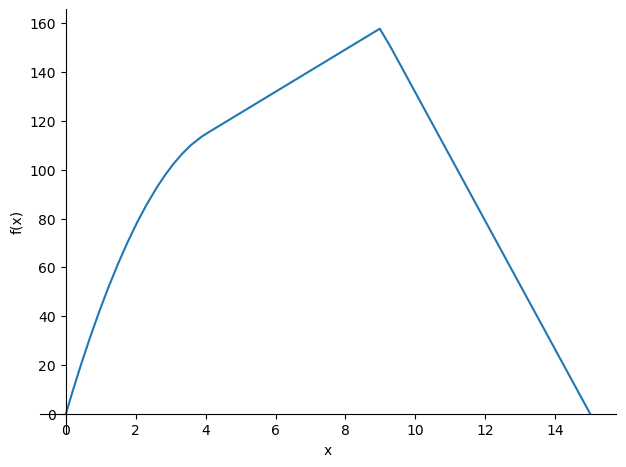

In [5]:
M = M.subs(sol)
sp.plotting.plot(M,(x,0,L));

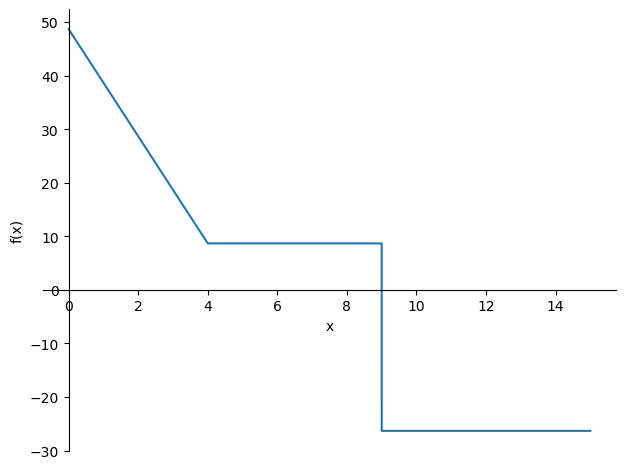

In [6]:
V = V.subs(sol)
sp.plotting.plot(V,(x,0,L));

## Alternative implementation with Singularity Functions

As you may have noticed, the evaluation of the result of the `Heaviside` and `DiracDelta` function takes a while. An alternative implementation is to make use of the `SingularityFunction`, which evaluates down to the `Heaviside` function for $n = 0$ and the `DiracDelta` function for $n=1$:
$$\matrix{
   n & {{{\langle x - a\rangle }^n}} & {{\text{Physical meaning}}}  \cr 
   { - 2} & {{\kern 1pt} {d \over {dx}}\delta \left( {x - a} \right){\kern 1pt} {\kern 1pt} } & {{\text{Unit moment at }}x = a}  \cr 
   { - 1} & {\delta \left( {x - a} \right)} & {{\text{Unit force at }}x = a}  \cr 
   0 & {H\left( {x - a} \right){\kern 1pt} } & {{\text{Start distributed load at }}x = a}  \cr 
   1 & {\left( {x - a} \right)H\left( {x - a} \right){\kern 1pt} } & {{\text{Start linear distributed load at }}x = a}  \cr 
   { > 0} & {{{\left( {x - a} \right)}^n}H\left( {x - a} \right)} & {{\text{Start polynomial at }}x = a}  \cr } $$

These functions are easily integrated according to the following rules:
$$\int {{{\left\langle {x - a} \right\rangle }^n}dx}  = \left\{ {\matrix{
   {{{\left\langle {x - a} \right\rangle }^{n + 1}}} & {{\text{if }}n < 0}  \cr 
   {{{{{\left\langle {x - a} \right\rangle }^{n + 1}}} \over {n + 1}}} & {{\text{if }}n \ge 0}  \cr  } } \right.$$

10*SingularityFunction(x, 0, 0) - 10*SingularityFunction(x, 4, 0) + 35*SingularityFunction(x, 9, -1)

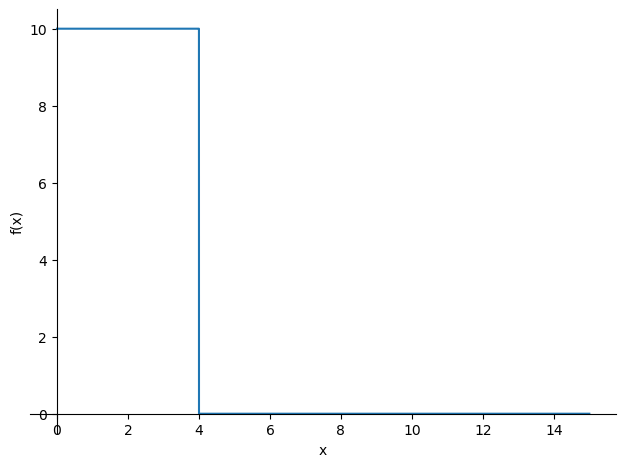

In [7]:
import sympy as sp
w = sp.symbols('w', cls=sp.Function)
x = sp.symbols('x')
C1, C2, C3, C4 = sp.symbols('C1 C2 C3 C4') 

Q = 10
L = 15
a = 4
b = 5
F = 35

q = Q*sp.SingularityFunction(x,0,0) - Q * sp.SingularityFunction(x,a,0) +F*sp.SingularityFunction(x,a+b,-1)
display(q)
sp.plot(q,(x,0,L));

As the `Singularity` function is easily integrated, the differential equation is solved by integrating the displacement function `q` four times.

In [8]:
EI = 10000
V = sp.integrate(-q,x)+C1
M = sp.integrate(V,x)+C2
kappa = M / EI
phi = sp.integrate(kappa,x)+C3
w = sp.integrate(-phi,x)+C4
display(w)

-C1*x**3/60000 - C2*x**2/20000 - C3*x + C4 + SingularityFunction(x, 0, 4)/24000 - SingularityFunction(x, 4, 4)/24000 + 7*SingularityFunction(x, 9, 3)/12000

The boundary conditions are now included in a similar manner as before, which leads to a neat solution.

In [9]:
Eq1 = sp.Eq(w.subs(x,0),0)
Eq2 = sp.Eq(w.subs(x,L),0)
Eq3 = sp.Eq(M.subs(x,0),0)
Eq4 = sp.Eq(M.subs(x,L),0)

sol = sp.solve((Eq1,Eq2,Eq3,Eq4),(C1,C2,C3,C4))
w = w.subs(sol)
display(w)

-73*x**3/90000 + 6673*x/90000 + SingularityFunction(x, 0, 4)/24000 - SingularityFunction(x, 4, 4)/24000 + 7*SingularityFunction(x, 9, 3)/12000

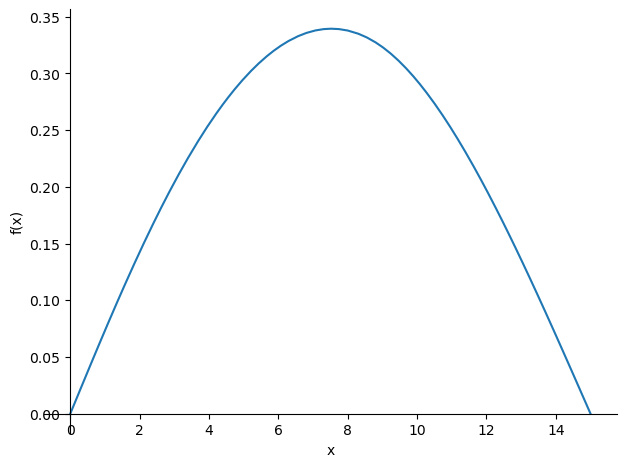

In [10]:
sp.plotting.plot(w,(x,0,L));

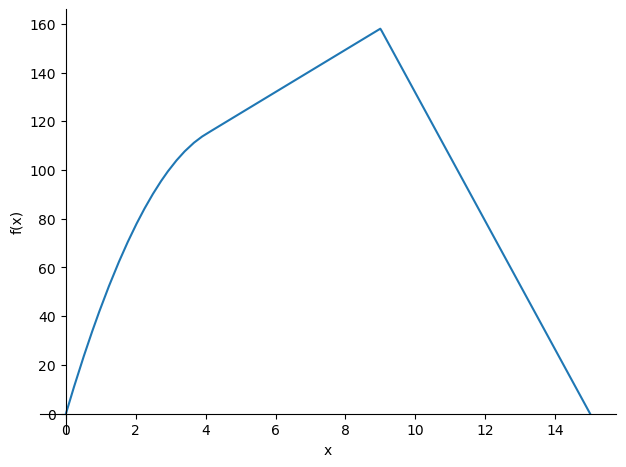

In [11]:
M = M.subs(sol)
sp.plotting.plot(M,(x,0,L));

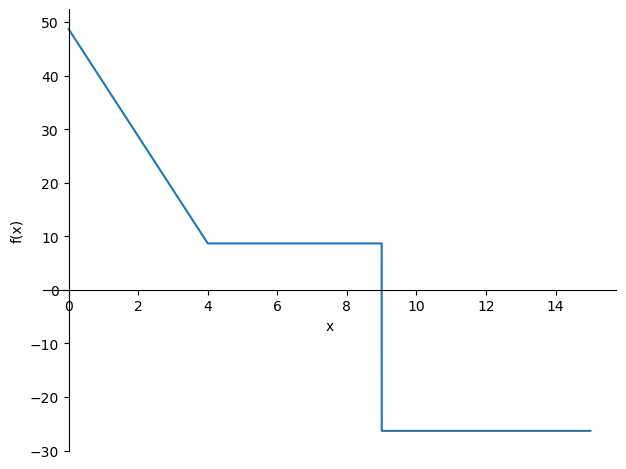

In [12]:
V = V.subs(sol)
sp.plotting.plot(V,(x,0,L));

## <a id='3_ODE'></a>Alternative implementation
Another alternative implementation is to split the beam in three sepeterate DEs, thus avoid the use of the special functions:

x**4/24000 - 73*x**3/90000 + 6673*x/90000

-13*x**3/90000 - x**2/250 + 7633*x/90000 - 4/375

79*x**3/180000 - 79*x**2/4000 + 40781*x/180000 - 5231/12000

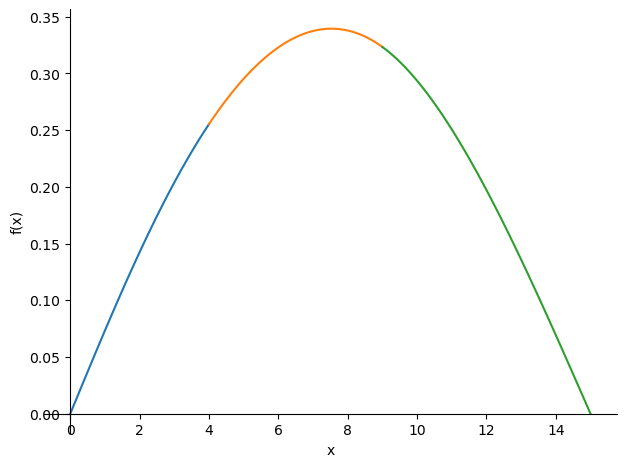

In [13]:
import sympy as sp
w1, w2, w3 = sp.symbols('w1 w2 w3', cls=sp.Function)
x = sp.symbols('x')
C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12 = sp.symbols('C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C11 C12') 

L = 15
a = 4
b = 5
F = 35
q = 10
EI = 10000

diffeq1 = sp.Eq(EI*w1(x).diff(x,4),q)
diffeq2 = sp.Eq(EI*w2(x).diff(x,4),0)
diffeq3 = sp.Eq(EI*w3(x).diff(x,4),0)

w1, w2, w3 = sp.dsolve([diffeq1, diffeq2, diffeq3],[w1(x), w2(x), w3(x)])
w1 = w1.rhs
w2 = w2.rhs
w3 = w3.rhs

phi1 = -sp.diff(w1,x)
kappa1 = sp.diff(phi1,x)
M1 = EI * kappa1
V1 = sp.diff(M1,x)
phi2 = -sp.diff(w2,x)
kappa2 = sp.diff(phi2,x)
M2 = EI * kappa2
V2 = sp.diff(M2,x)
phi3 = -sp.diff(w3,x)
kappa3 = sp.diff(phi3,x)
M3 = EI * kappa3
V3 = sp.diff(M3,x)

Eq1 = sp.Eq(w1.subs(x,0),0)
Eq2 = sp.Eq(M1.subs(x,0),0)

Eq3 = sp.Eq(  w1.subs(x, a),   w2.subs(x, a))
Eq4 = sp.Eq(  M1.subs(x, a),   M2.subs(x, a))
Eq5 = sp.Eq(  V1.subs(x, a),   V2.subs(x, a))
Eq6 = sp.Eq(phi1.subs(x, a), phi2.subs(x, a))

Eq7 = sp.Eq(  w2.subs(x, a + b),   w3.subs(x, a + b))
Eq8 = sp.Eq(  M2.subs(x, a + b),   M3.subs(x, a + b))
Eq9 = sp.Eq(  V2.subs(x, a + b),   V3.subs(x, a + b) + F)
Eq10= sp.Eq(phi2.subs(x, a + b), phi3.subs(x, a + b))

Eq11= sp.Eq(w3.subs(x, L), 0)
Eq12= sp.Eq(M3.subs(x, L), 0)

sol = sp.solve((Eq1, Eq2, Eq3, Eq4, Eq5, Eq6, Eq7, Eq8, Eq9, Eq10, Eq11, Eq12),
               ( C1,  C2,  C3,  C4,  C5,  C6,  C7,  C8,  C9,  C10,  C11,  C12))

w1_sol = w1.subs(sol)
w2_sol = w2.subs(sol)
w3_sol = w3.subs(sol)
display(w1_sol)
display(w2_sol)
display(w3_sol)

sp.plotting.plot((w1_sol,(x,0,a)),(w2_sol,(x,a,a+b)),(w3_sol,(x,a+b,L)));

## Alternative plotting

Furthermore, the (more extensive) plot functions of the `matplotlib` library can be used when the results are written to `numpy` functions. The use of these libraries is not advised in combination with the `Heaviside` and `DiracDelta` functions.

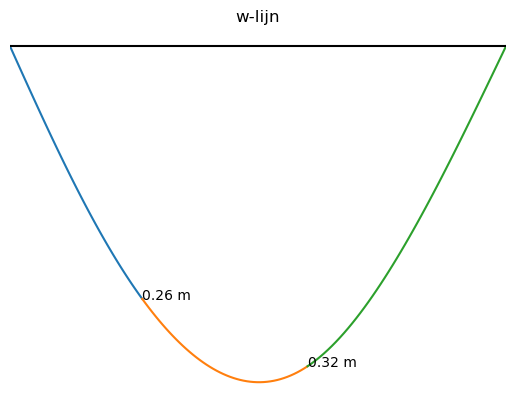

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x1_plot = np.linspace(0    , a    , 50)
x2_plot = np.linspace(a    , a + b, 50)
x3_plot = np.linspace(a + b, L    , 50)
w1_numpy = sp.lambdify(x,w1_sol)
w2_numpy = sp.lambdify(x,w2_sol)
w3_numpy = sp.lambdify(x,w3_sol)
w1_plot = w1_numpy(x1_plot)
w2_plot = w2_numpy(x2_plot)
w3_plot = w3_numpy(x3_plot)
plt.plot(x1_plot,w1_plot)
plt.plot(x2_plot,w2_plot)
plt.plot(x3_plot,w3_plot)
plt.gca().invert_yaxis()
plt.title("w-lijn")
plt.axhline(0,color='black')
plt.xlim(0,L)
plt.annotate('%.2f m' % w1_numpy(a),xy = [a,w1_numpy(a)])
plt.annotate('%.2f m' % w2_numpy(a+b),xy = [a+b,w2_numpy(a+b)])
plt.axis('off');

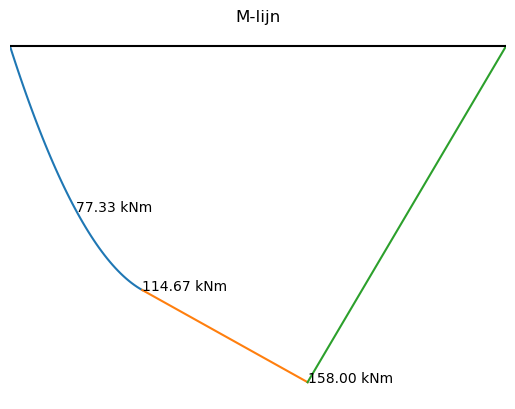

In [15]:
M1_sol = M1.subs(sol)
M2_sol = M2.subs(sol)
M3_sol = M3.subs(sol)
M1_numpy = sp.lambdify(x,M1_sol)
M2_numpy = sp.lambdify(x,M2_sol)
M3_numpy = sp.lambdify(x,M3_sol)
M1_plot = M1_numpy(x1_plot)
M2_plot = M2_numpy(x2_plot)
M3_plot = M3_numpy(x3_plot)
plt.figure()
plt.plot(x1_plot,M1_plot)
plt.plot(x2_plot,M2_plot)
plt.plot(x3_plot,M3_plot)
plt.gca().invert_yaxis()
plt.title("M-lijn")
plt.axhline(0,color='black')
plt.xlim(0,L)
plt.annotate('%.2f kNm' % M1_numpy(a/2),xy = [a/2,M1_numpy(a/2)])
plt.annotate('%.2f kNm' % M1_numpy(a),xy = [a,M1_numpy(a)])
plt.annotate('%.2f kNm' % M2_numpy(a+b),xy = [a+b,M2_numpy(a+b)])
plt.axis('off');

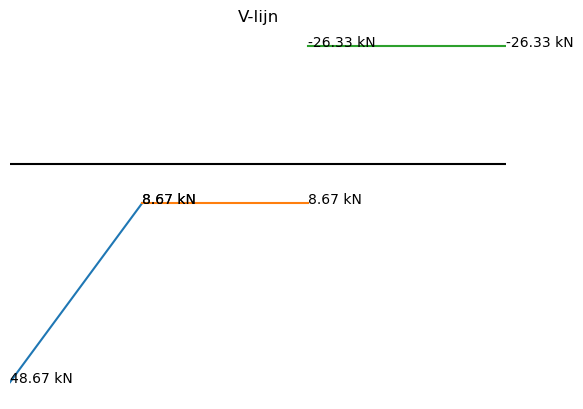

In [16]:
V1_sol = V1.subs(sol)
V2_sol = V2.subs(sol)
V3_sol = V3.subs(sol)
V1_numpy = sp.lambdify(x,V1_sol)
V2_numpy = sp.lambdify(x,V2_sol)
V3_numpy = sp.lambdify(x,V3_sol)
V1_plot = V1_numpy(x1_plot)
V2_plot = V2_numpy(x2_plot)
V3_plot = V3_numpy(x3_plot)
plt.figure()
plt.plot(x1_plot,V1_plot)
plt.plot([a,a+b],[V2_plot,V2_plot])
plt.plot([a+b,L],[V3_plot,V3_plot])
plt.gca().invert_yaxis()
plt.title("V-lijn")
plt.axhline(0,color='black')
plt.xlim(0,L) 
plt.annotate('%.2f kN' % V1_numpy(0),xy = [0,V1_numpy(0)])
plt.annotate('%.2f kN' % V1_numpy(a),xy = [a,V1_numpy(a)])
plt.annotate('%.2f kN' % V2_numpy(a),xy = [a,V2_numpy(a)])
plt.annotate('%.2f kN' % V2_numpy(a+b),xy = [a+b,V2_numpy(a+b)])
plt.annotate('%.2f kN' % V3_numpy(a+b),xy = [a+b,V3_numpy(a+b)])
plt.annotate('%.2f kN' % V3_numpy(L),xy = [L,V3_numpy(L)])
plt.axis('off');